In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from tshelpers.plot import plot_missing

sns.set_theme(style="ticks", palette="mako")
warnings.filterwarnings("ignore", category=UserWarning)

### Visualizations Style

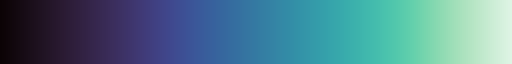

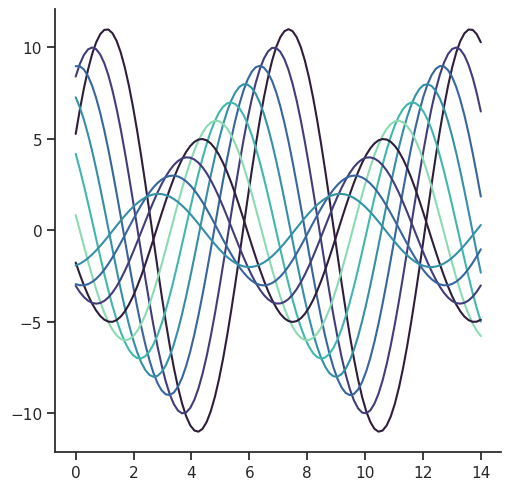

In [99]:
plt.figure(figsize=(5.75, 5.75))
def sinplot(n=10, flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, n + 1):
        plt.plot(x, np.sin(x + i * .5) * (n + 2 - i) * flip)

sinplot()
sns.despine()
sns.color_palette("mako", as_cmap=True)

### Master DataFrame

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


### Time Series Plot

In [32]:
master_df_melt = pd.melt(master_df.iloc[:, :4].resample("24H").mean(numeric_only=True).rename(),
                         value_vars=[
                            "Vancouver_Clark_Drive_PM25",\
                            "Vancouver_International_Airport_#2_PM25",\
                            "North_Vancouver_Mahon_Park_PM25",\
                            "North_Vancouver_Second_Narrows_PM25"
                            ],
                         ignore_index=False).rename(columns={
                            "variable": "Station",
                            "value": "PM 2.5"})
master_df_melt

,Station,PM 2.5
DATE_PST,,
2016-01-01,Vancouver_Clark_Drive_PM25,20.158652
2016-01-02,Vancouver_Clark_Drive_PM25,16.973417
2016-01-03,Vancouver_Clark_Drive_PM25,11.404792
2016-01-04,Vancouver_Clark_Drive_PM25,15.060409
2016-01-05,Vancouver_Clark_Drive_PM25,11.371000
...,...,...
2022-06-29,North_Vancouver_Second_Narrows_PM25,3.327361
2022-06-30,North_Vancouver_Second_Narrows_PM25,5.023754
2022-07-01,North_Vancouver_Second_Narrows_PM25,5.035238


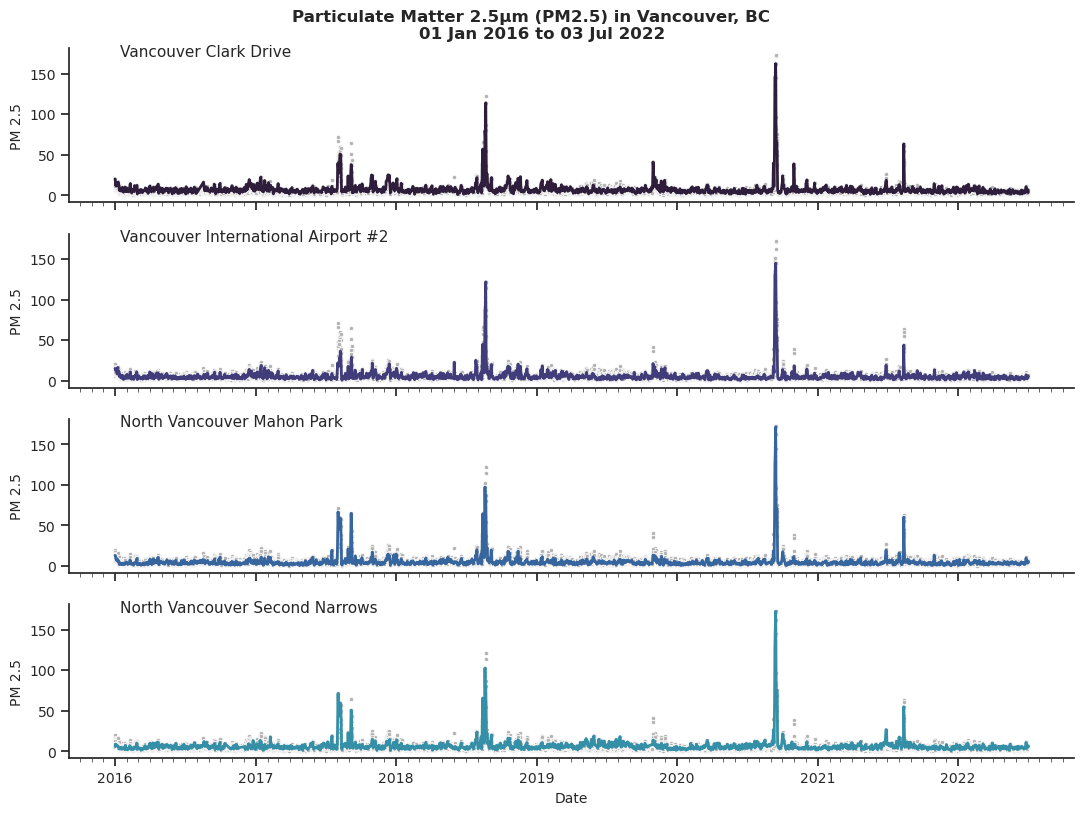

In [80]:
rel = sns.relplot(master_df_melt,
                  x="DATE_PST",
                  y="PM 2.5",
                  col="Station",
                  hue="Station",
                  kind="line",
                  linewidth=2,
                  col_wrap=1,
                  height=2,
                  aspect=5.5,
                  zorder=5,
                  legend=False)

for station, ax in rel.axes_dict.items():
    ax.text(0.05, 0.95, station.replace('_', ' ')[:-4], transform=ax.transAxes, fontsize=11)
    sns.scatterplot(master_df_melt,
                 x="DATE_PST",
                 y="PM 2.5",
                 marker='.',
                 color=".7",
                 ax=ax)
    ax.set_ylabel("PM 2.5", fontsize=10)
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.tick_params(which='major', labelsize=10)
    ax.tick_params(which='minor', length=3, width=0.5)
rel.set_titles("")
rel.tight_layout()
rel.set_xlabels("Date", fontsize=10)
plt.suptitle(f"Particulate Matter 2.5μm (PM2.5) in Vancouver, BC\
    \n{min(master_df_melt.index):%d %b %Y} to {max(master_df_melt.index):%d %b %Y}",
    y=1.02,
    fontsize=12,
    fontweight="bold")
plt.show()

### Summary Statistics

In [3]:
# Summary Statistics
master_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Vancouver_Clark_Drive_PM25,55487.0,7.45,9.60,0.0,3.48,5.56,8.55,214.87
Vancouver_International_Airport_#2_PM25,56467.0,5.57,8.33,0.0,2.30,3.94,6.48,209.59
North_Vancouver_Mahon_Park_PM25,56381.0,5.11,8.98,0.0,2.04,3.51,5.67,203.03
North_Vancouver_Second_Narrows_PM25,54763.0,6.68,8.64,0.0,3.12,4.95,7.69,188.93


### Missing Values

In [4]:
# Missing Values summary
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'})

,Missing,Missing %
Vancouver_Clark_Drive_PM25,1527,2.75
Vancouver_International_Airport_#2_PM25,547,0.97
North_Vancouver_Mahon_Park_PM25,633,1.12
North_Vancouver_Second_Narrows_PM25,2251,4.11


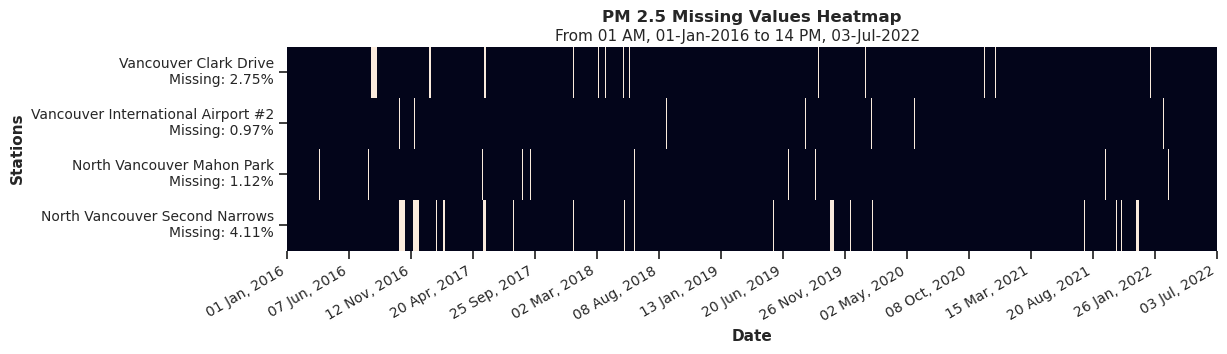

In [5]:
# Missing Values heatmap
plot_missing(master_df)

### Seasonalities

In [6]:
# Datepart features to inspect seasonalities
master_df['Month'] = master_df.index.month
master_df['Day_of_Week'] = master_df.index.day_name()
master_df['Hour'] = master_df.index.hour

master_df.iloc[:, 3:].head()

,North_Vancouver_Second_Narrows_PM25,Month,Day_of_Week,Hour
DATE_PST,,,,
2016-01-01 01:00:00,NaN,1,Friday,1
2016-01-01 02:00:00,6.341111,1,Friday,2
2016-01-01 03:00:00,5.340278,1,Friday,3
2016-01-01 04:00:00,3.907917,1,Friday,4
2016-01-01 05:00:00,7.235889,1,Friday,5


In [7]:
# Percentile cutoff
percentile = 0.95

# Subsets with top percentile cutoff
subsets = {}
for station in master_df.columns[:4]:
    subsets[station] = master_df[[station, 'Month', 'Day_of_Week', 'Hour']]
    subsets[station] = subsets[station][
        subsets[station][station] < subsets[station][station].quantile(percentile)
    ]

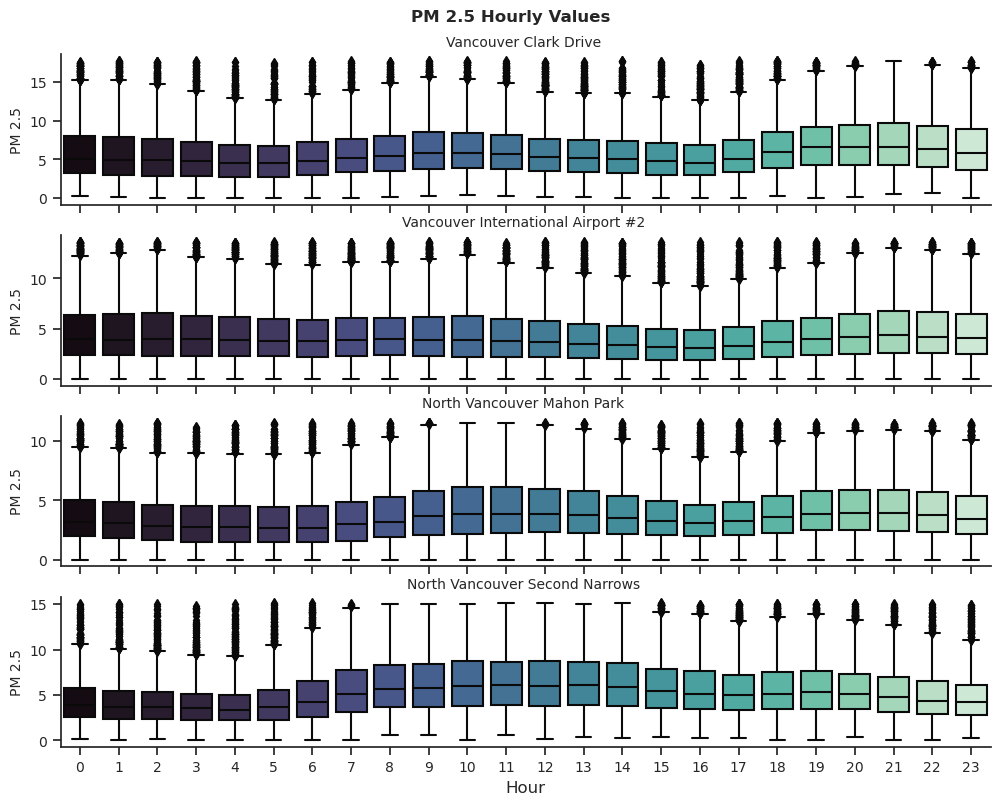

In [89]:
def seasonal_plots(subsets,
                   interval='Hour',
                   palette='mako',
                   figsize=(12, 9),
                   plot_title="",
                   xlabel="",
                   x_labelrotation=None):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=figsize)
    for i, station in enumerate(master_df.columns[:4]):
        if interval == 'Day_of_Week':
            order=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
        else:
            order = None
        b = sns.boxplot(ax=ax[i],
                    data=subsets[station],
                    x = interval,
                    y = station,
                    palette=palette,
                    order=order)
        ax[i].tick_params(axis='both', labelsize=10)
        ax[i].tick_params(axis='x', labelrotation=x_labelrotation)
        ax[i].set_title("")
        b.set_title(f"{station.replace('_', ' ')[:-4]}", fontsize=10)
        b.set_ylabel("PM 2.5", fontsize=10)
        b.set_xlabel("")
        sns.despine()
    plt.suptitle(plot_title, y=0.93, fontsize=12, fontweight="bold")
    plt.xlabel(xlabel)
    plt.show()

# Hourly plots
seasonal_plots(subsets,
               interval='Hour',
               plot_title="PM 2.5 Hourly Values",
               xlabel="Hour")

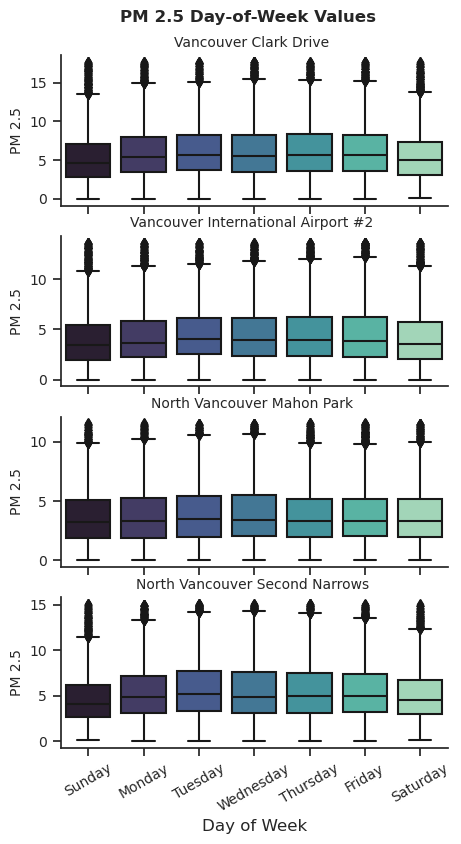

In [91]:
# Day-of-Week plots
seasonal_plots(subsets,
               interval='Day_of_Week',
               plot_title="PM 2.5 Day-of-Week Values",
               xlabel="Day of Week",
               figsize=(5, 9),
               x_labelrotation=30)

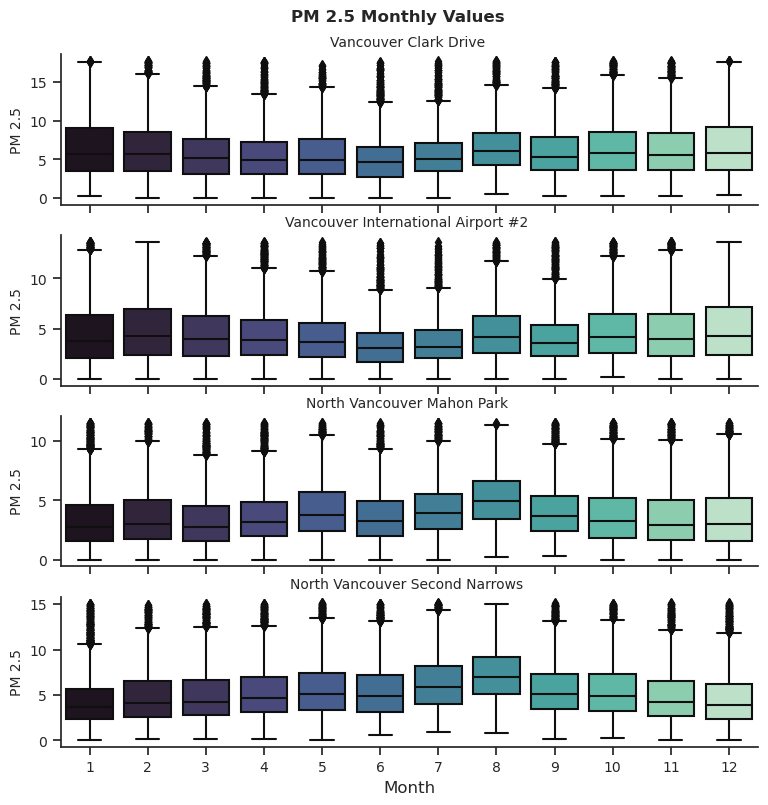

In [92]:
# Monthly plots
seasonal_plots(subsets,
               interval='Month',
               plot_title="PM 2.5 Monthly Values",
               xlabel="Month",
               figsize=(9, 9))

### Correlation

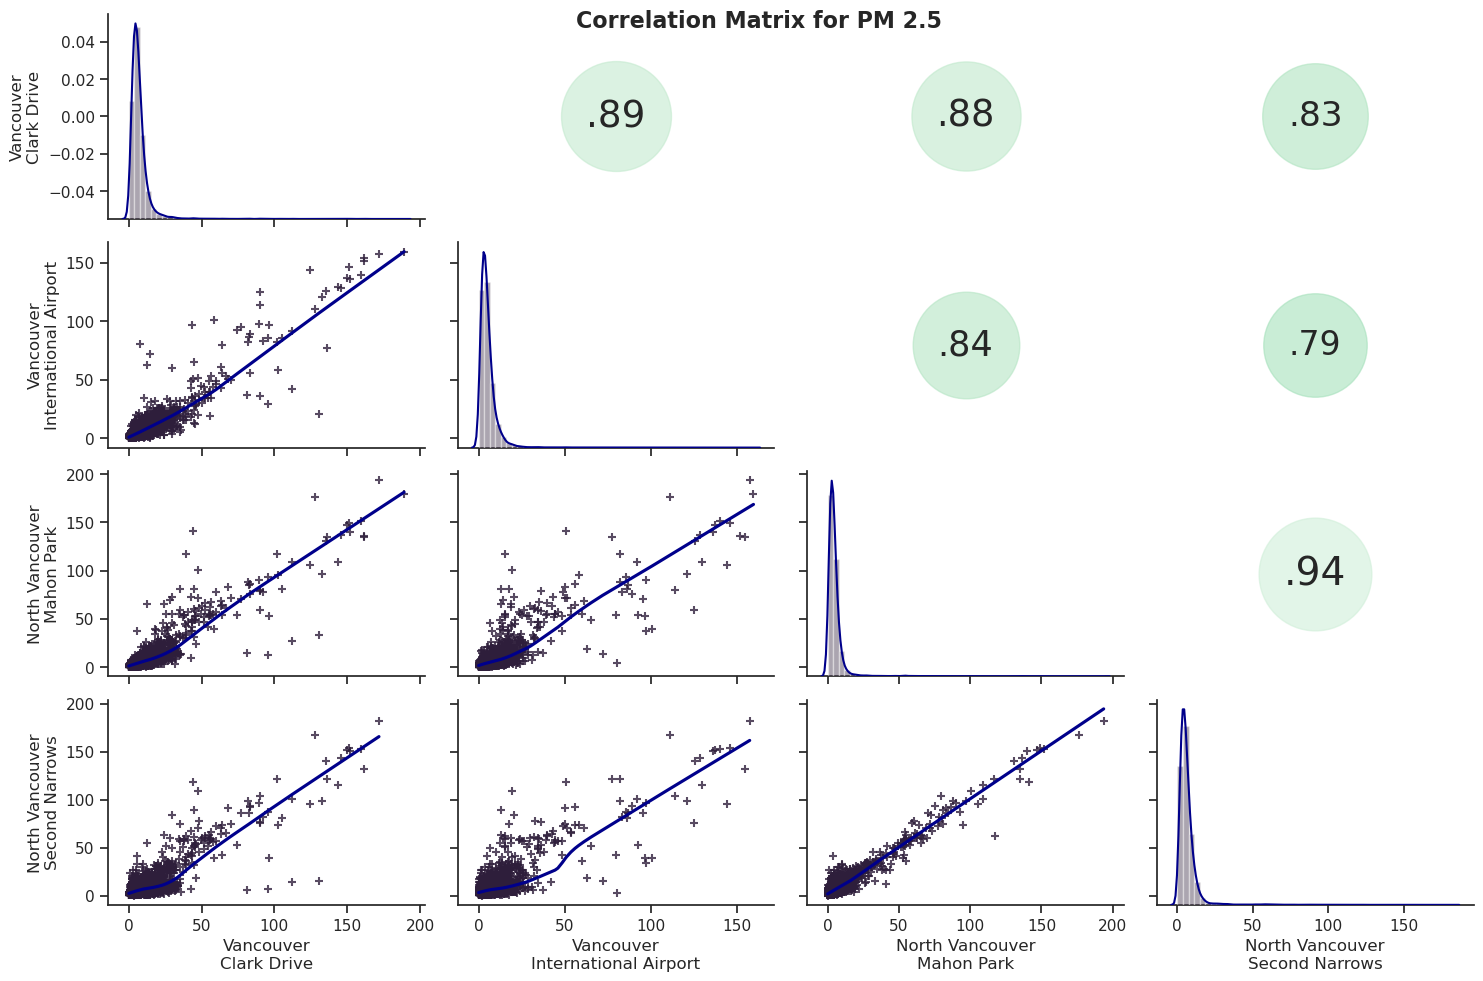

In [11]:
# Aggregation
agg_rule = "6H"

master_df_agg = master_df.resample(agg_rule).mean(numeric_only=True)
master_df_agg.rename(columns={
    "Vancouver_Clark_Drive_PM25": "Vancouver\nClark Drive",
    "Vancouver_International_Airport_#2_PM25": "Vancouver\nInternational Airport",
    "North_Vancouver_Mahon_Park_PM25": "North Vancouver\nMahon Park",
    "North_Vancouver_Second_Narrows_PM25": "North Vancouver\nSecond Narrows"},
    inplace=True)

# Correlation coefficient
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 7000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="mako",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 30
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

# PairGrid plot
g = sns.PairGrid(master_df_agg.iloc[:, :4],
                 aspect=1.5,                 
                 diag_sharey=False)
g.map_lower(sns.regplot, marker="+", lowess=True, ci=False, line_kws={'color':'darkblue'})
g.map_diag(sns.distplot, kde_kws={'color':'darkblue'})
g.map_upper(corrdot)
plt.suptitle("Correlation Matrix for PM 2.5", fontsize=16, fontweight="bold")
plt.show()

### Autocorrelation and Partial Autocorrelation

0
1


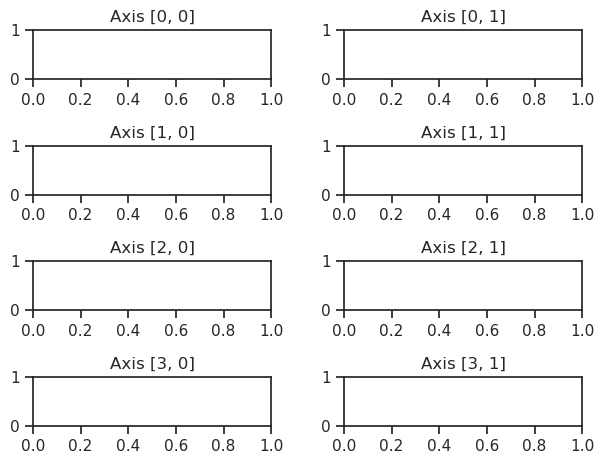

In [123]:
fig, axs = plt.subplots(4, 2)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].set_title('Axis [1, 1]')
axs[2, 0].set_title('Axis [2, 0]')
axs[2, 1].set_title('Axis [2, 1]')
axs[3, 0].set_title('Axis [3, 0]')
axs[3, 1].set_title('Axis [3, 1]')
plt.tight_layout()

for j in [0, 1]:
    print(j)

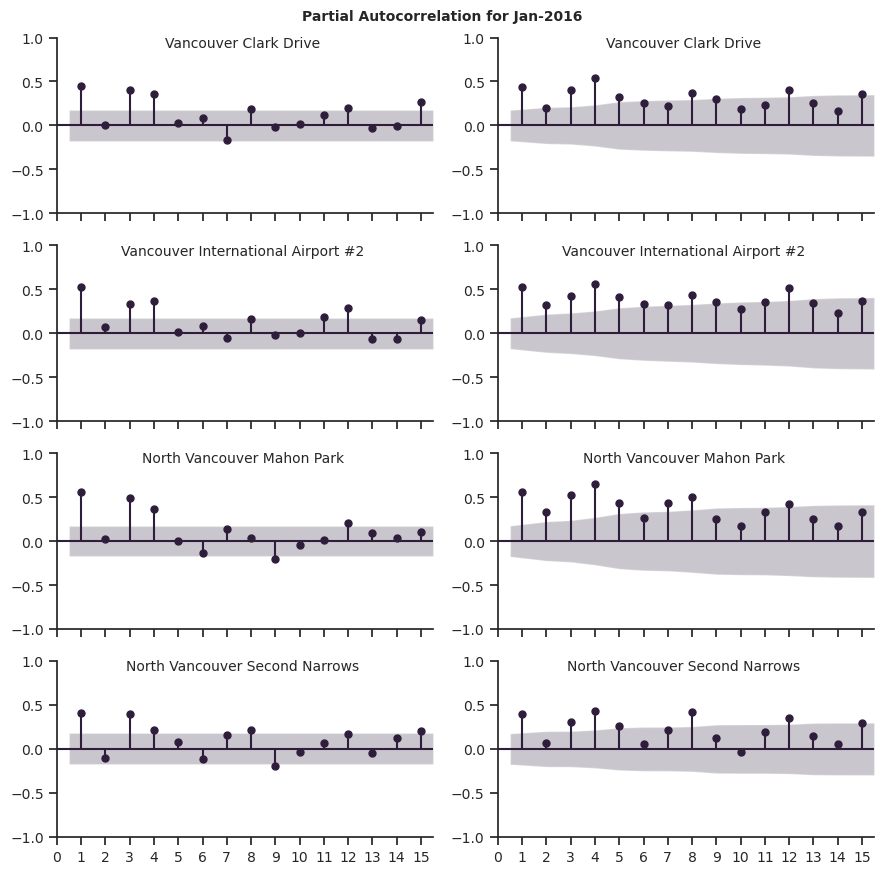

In [126]:
# PACF and ACF plot methods from statsmodels
from matplotlib.ticker import MultipleLocator
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Multiple PACF plot
def plot_multiple_pacf(data,
                       columns,
                       lags=15,
                       start=None,
                       end=None,
                       plot_title=None):
    if plot_title == None:
        plot_title="Partial Autocorrelation"
    fig, axs = plt.subplots(len(columns), 2, sharex=True, figsize=(9, 9))
    for i, column in enumerate(data[columns]):
        for j in [0, 1]:
            args = {
            "x": data[start:end][column],
            "lags": lags,
            "method": "yw",
            "ax": axs[i, j],
            "title": "",
            "zero": False
            }
            if j == 0:
                p = plot_pacf(**args)
            elif j == 1:
                p = plot_acf(**{parameter:args[parameter] for parameter in args if parameter!='method'})
            axs[i, j].xaxis.set_major_locator(MultipleLocator(1))
            axs[i, j].tick_params(labelsize=10)
            axs[i, j].set_title(f"{column.replace('_', ' ')[:-4]}", fontsize=10, y=0.9)
            sns.despine()

            p.set_tight_layout(1)
    plt.suptitle(plot_title,
                y=0.97,
                fontsize=10,
                fontweight="bold")
    plt.xlim([0, lags+0.5])
    plt.show()

# Aggregation and Forward Fill
agg_rule = "6H"
master_df_agg = master_df.resample(agg_rule).mean(numeric_only=True).interpolate()

# PACF for January 2016
plot_multiple_pacf(master_df_agg,
                   master_df_agg.columns[:4],
                   start=datetime(2016, 1, 1),
                   end=datetime(2016, 2, 1),
                   plot_title="Partial Autocorrelation for Jan-2016")

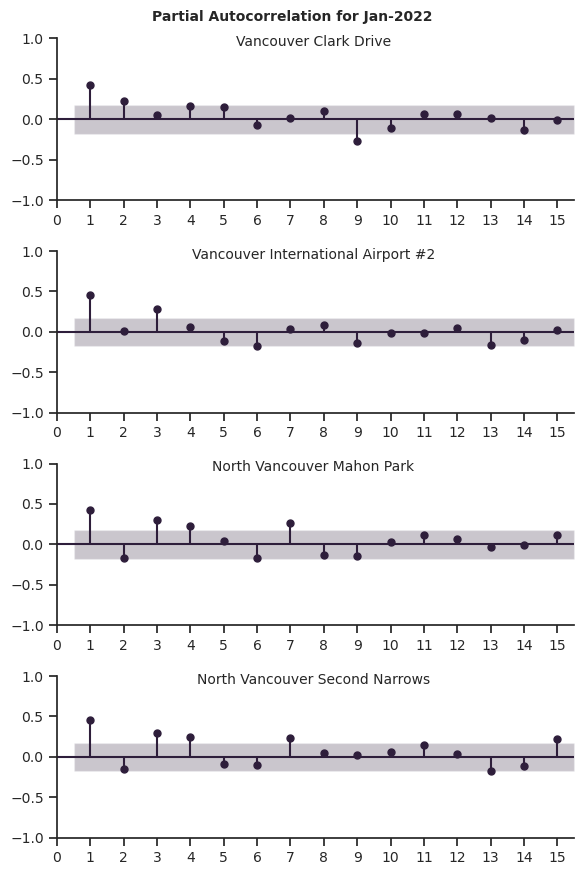

In [14]:
# PACF for January 2022
plot_multiple_pacf(master_df_agg,
                   master_df_agg.columns[:4],
                   start=datetime(2022, 1, 1),
                   end=datetime(2022, 2, 1),
                   plot_title="Partial Autocorrelation for Jan-2022")

> On a 6h aggregation, it seems that lags 1, 3, and 4 (t-6h, t-18h, and t-24h) shows significant PACF

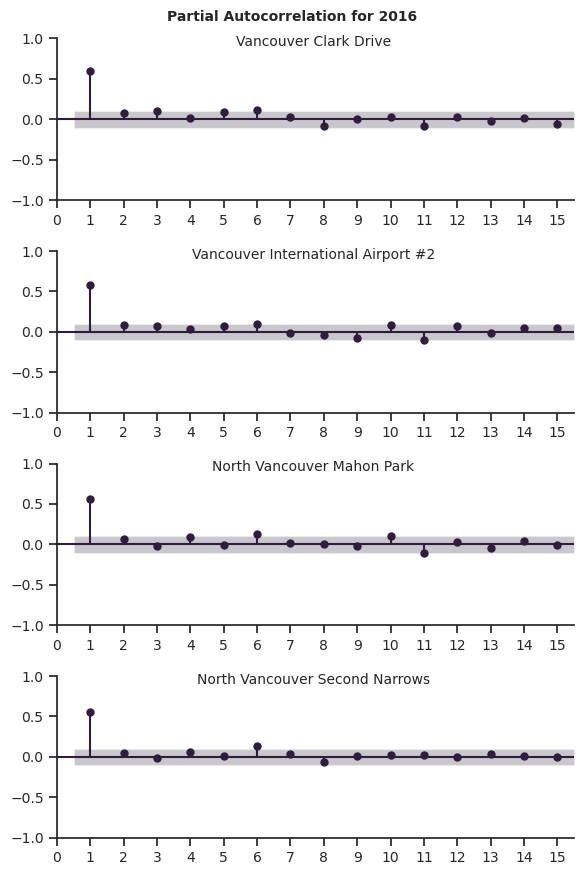

In [16]:
# PACF for January 2016 to January 2017
# Aggregation and Forward Fill
agg_rule = "24H"
master_df_agg = master_df.resample(agg_rule).mean(numeric_only=True).interpolate()

plot_multiple_pacf(master_df_agg,
                   master_df_agg.columns[:4],
                   start=datetime(2016, 1, 1),
                   end=datetime(2017, 1, 1),
                   plot_title="Partial Autocorrelation for 2016")

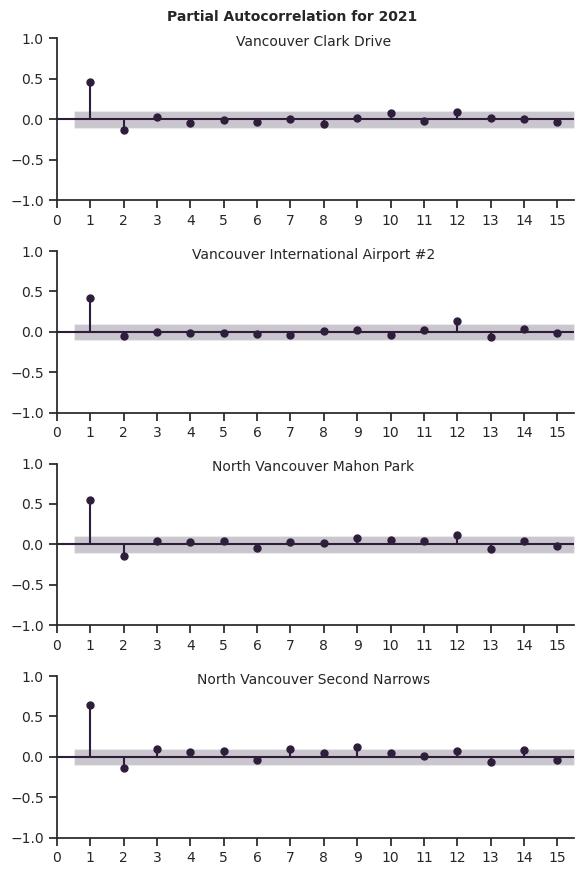

In [17]:
# PACF for January 2021 to January 2022
plot_multiple_pacf(master_df_agg,
                   master_df_agg.columns[:4],
                   start=datetime(2021, 1, 1),
                   end=datetime(2022, 1, 1),
                   plot_title="Partial Autocorrelation for 2021")

> On a 24h aggregation, it seems that only lag 1 (t-24h) shows significant PACF

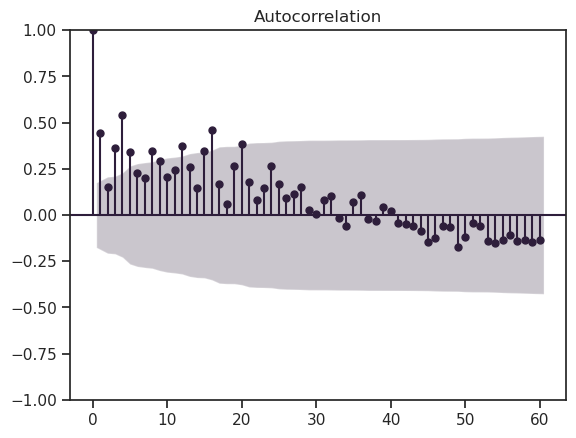

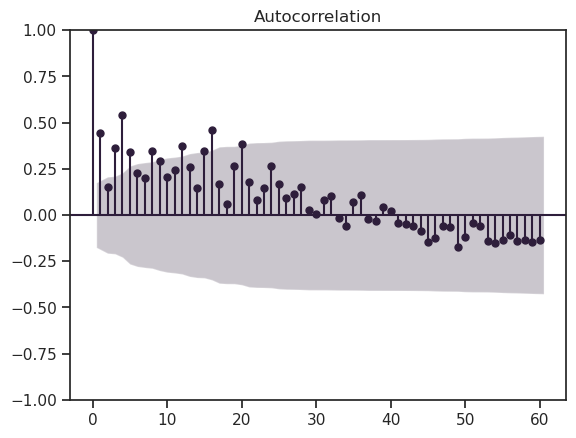

In [161]:
# ACF
plot_acf(master_df[datetime(2016, 1, 1):datetime(2016, 2, 1)]["Vancouver_Clark_Drive_PM25"].resample("6H").mean(numeric_only=True).ffill(),
lags=60)

---
## Updated Version is from here and up
---

In [7]:
# Reading original datasets
paths = glob("data/*.csv")
paths

NameError: name 'glob' is not defined

In [ ]:
# Reading datasets
datasets = {}
for path in paths:
    datasets[str(path[5:-4])] = pd.read_csv(path)

datasets_list = sorted(list(datasets.keys()))
datasets_list

['PM25_2016', 'PM25_2017', 'PM25_2018', 'PM25_2019', 'PM25_2020', 'PM25_2021']

In [ ]:
# Dataset dimensions
for dataset in datasets_list:
    print(f"{dataset} dim: {datasets[dataset].shape}")

PM25_2016 dim: (529763, 14)
PM25_2017 dim: (606525, 14)
PM25_2018 dim: (557717, 14)
PM25_2019 dim: (566637, 14)
PM25_2020 dim: (564130, 14)
PM25_2021 dim: (869059, 11)


In [ ]:
# Summary statistics
for dataset in datasets_list:
    print(f"Summary statistics for {dataset}")
    summary_df = {}
    summary_df["Variable"] = []
    summary_df["Uniques"] = []
    summary_df["Missing"] = []
    summary_df["Min"] = []
    summary_df["Max"] = []
    summary_df["Mean"] = []

    for column in datasets[dataset].columns:
        summary_df["Variable"].append(column)
        uniques = len(pd.unique(datasets[dataset][column]))
        summary_df["Uniques"].append(uniques)
        missing = sum(datasets[dataset][column].isna())
        missing_pct = missing / datasets[dataset].shape[0] * 100
        if missing:
            summary_df["Missing"].append(f"{missing_pct:.2f} %")
        else:
            summary_df["Missing"].append("-")
        if (
            datasets[dataset][column].values.dtype in ["float64", "int64"]
            and "ID" not in column
        ):
            summary_df["Min"].append(round(datasets[dataset][column].min(), 3))
            summary_df["Max"].append(round(datasets[dataset][column].max(), 3))
            summary_df["Mean"].append(round(datasets[dataset][column].mean(), 3))
        else:
            summary_df["Min"].append("-")
            summary_df["Max"].append("-")
            summary_df["Mean"].append("-")

    print(tabulate(pd.DataFrame(summary_df), headers="keys", tablefmt="psql") + "\n")

Summary statistics for PM25_2016
+----+-------------------+-----------+-----------+--------+---------+--------+
|    | Variable          |   Uniques | Missing   | Min    | Max     | Mean   |
|----+-------------------+-----------+-----------+--------+---------+--------|
|  0 | DATE_PST          |      8784 | -         | -      | -       | -      |
|  1 | DATE              |       366 | -         | -      | -       | -      |
|  2 | TIME              |        24 | -         | -      | -       | -      |
|  3 | STATION_NAME      |        63 | -         | -      | -       | -      |
|  4 | STATION_NAME_FULL |        63 | -         | -      | -       | -      |
|  5 | EMS_ID            |        63 | -         | -      | -       | -      |
|  6 | NAPS_ID           |        39 | -         | -      | -       | -      |
|  7 | RAW_VALUE         |    298200 | 6.06 %    | -0.137 | 605.228 | 5.508  |
|  8 | ROUNDED_VALUE     |      1020 | 6.06 %    | -0.1   | 605.2   | 5.508  |
|  9 | UNIT        

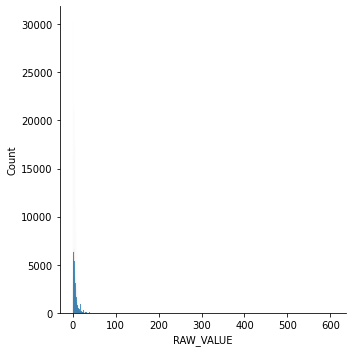

In [ ]:
# Univariate outlier detection
sns.displot(datasets["PM25_2016"]["RAW_VALUE"])

Cutoff at RAW_VALUE: 28.349 for percentile: 0.99


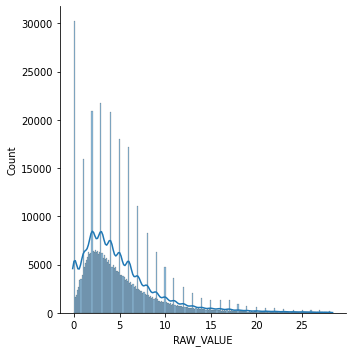

In [ ]:
# Distribution plot on percentile threshold
percentile = 0.99

quantile = datasets["PM25_2016"]["RAW_VALUE"].quantile(percentile)
print(f"Cutoff at RAW_VALUE: {quantile:.3f} for percentile: {percentile}")
sns.displot(
    datasets["PM25_2016"][datasets["PM25_2016"]["RAW_VALUE"] < quantile]["RAW_VALUE"],
    kde=True,
)
plt.show()

Investigating threshold at > 300

reference: https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air

In [ ]:
# Investigating threshold at raw value > 300
threshold = 300

for dataset in datasets_list:
    print(f"Subset of {dataset} at RAW_VALUE > {threshold}")
    try:
        subset = datasets[dataset][datasets[dataset]["RAW_VALUE"] > threshold][
            ["DATE_PST", "STATION_NAME", "RAW_VALUE", "REGION"]
        ]
        print(
            f"Subset size: {len(subset)} ({len(subset)/len(datasets[dataset]) * 100:.3f} %)"
        )
        print(tabulate(subset, headers="keys", tablefmt="psql") + "\n")
    except KeyError:
        pass

Subset of PM25_2016 at RAW_VALUE > 300
Subset size: 19 (0.004 %)
+--------+------------------+----------------+-------------+--------------------+
|        | DATE_PST         | STATION_NAME   |   RAW_VALUE | REGION             |
|--------+------------------+----------------+-------------+--------------------|
| 502807 | 2016-12-06 21:00 | Valemount      |     390.475 | 07 - Omineca-Peace |
| 502808 | 2016-12-06 22:00 | Valemount      |     499.013 | 07 - Omineca-Peace |
| 502809 | 2016-12-06 23:00 | Valemount      |     352.349 | 07 - Omineca-Peace |
| 502810 | 2016-12-07 00:00 | Valemount      |     345.078 | 07 - Omineca-Peace |
| 502811 | 2016-12-07 01:00 | Valemount      |     605.227 | 07 - Omineca-Peace |
| 502812 | 2016-12-07 02:00 | Valemount      |     432.655 | 07 - Omineca-Peace |
| 502813 | 2016-12-07 03:00 | Valemount      |     315.796 | 07 - Omineca-Peace |
| 502818 | 2016-12-07 08:00 | Valemount      |     374.959 | 07 - Omineca-Peace |
| 502819 | 2016-12-07 09:00 | Val

In [ ]:
# Unique stations
stations = []
for dataset in datasets_list:
    for station in pd.unique(datasets[dataset]["STATION_NAME"]):
        if station not in stations:
            stations.append(station)

print(f"Total unique stations: {len(stations)}")

Total unique stations: 87


In [ ]:
# Unique regions
regions = []
for dataset in datasets_list:
    try:
        for region in pd.unique(datasets[dataset]["REGION"]):
            if region not in regions:
                regions.append(region)
    except KeyError:
        pass

print(f"Total unique regions: {len(regions)}")

Total unique regions: 7


In [ ]:
# Unique stations per region
stations_per_region = {}
print("Unique stations per region")
for dataset in datasets_list:
    try:
        stations_per_region[dataset[-4:]] = (
            datasets[dataset].groupby("REGION")["STATION_NAME"].nunique()
        )
    except KeyError:
        pass

print(tabulate(pd.concat(stations_per_region, axis=1), headers="keys", tablefmt="psql"))

Unique stations per region
+------------------------+--------+--------+--------+--------+--------+
| REGION                 |   2016 |   2017 |   2018 |   2019 |   2020 |
|------------------------+--------+--------+--------+--------+--------|
| 01 - Vancouver Island  |     11 |     12 |     13 |     11 |     11 |
| 02 - Lower Mainland    |     27 |     27 |     27 |     25 |     25 |
| 03 - Southern Interior |      5 |      5 |      5 |      7 |      3 |
| 04 - Kootenay          |      3 |      4 |      4 |      4 |      4 |
| 05 - Cariboo           |      2 |      2 |      2 |      2 |      3 |
| 06 - Skeena            |     10 |     10 |      8 |      9 |      9 |
| 07 - Omineca-Peace     |      5 |     11 |      9 |      8 |      9 |
+------------------------+--------+--------+--------+--------+--------+


In [ ]:
# Aggregating datasets on region and by mean daily raw value accross stations
for dataset in datasets_list:
    try:
        grouped = datasets[dataset].groupby(["REGION", "DATE"]).mean().reset_index()
    except KeyError:
        pass

    # Filtering out unwanted columns
    datasets[f"{dataset}_AGG"] = grouped[["REGION", "DATE", "RAW_VALUE"]]
    print(f"{dataset}_AGG dim: {datasets[f'{dataset}_AGG'].shape}")

PM25_2016_AGG dim: (2562, 3)
PM25_2017_AGG dim: (2555, 3)
PM25_2018_AGG dim: (2555, 3)
PM25_2019_AGG dim: (2555, 3)
PM25_2020_AGG dim: (2562, 3)
PM25_2021_AGG dim: (2562, 3)


In [ ]:
# Time Series relationship subset plot function
def plot_ts(data, date, value, value_label, subset, col_wrap=1, height=3, aspect=4):
    # Seaborn relplot
    grid = sns.relplot(
        data=data,
        x=date,
        y=value,
        col=subset,
        hue=subset,
        kind="line",
        palette="dark:salmon_r",
        linewidth=3,
        zorder=5,
        col_wrap=col_wrap,
        height=height,
        aspect=aspect,
        legend=False,
    )

    # Semantic foreground plot of subsets
    for time, ax in grid.axes_dict.items():
        ax.text(0.1, 0.85, time, transform=ax.transAxes, fontsize=12, fontweight="bold")
        sns.lineplot(
            data=data,
            x=date,
            y=value,
            units=subset,
            estimator=None,
            color=".7",
            linewidth=1,
            ax=ax,
        )

    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.tick_params(labelsize=12)
    grid.set_titles("")
    grid.set_axis_labels("", value_label)
    grid.tight_layout()

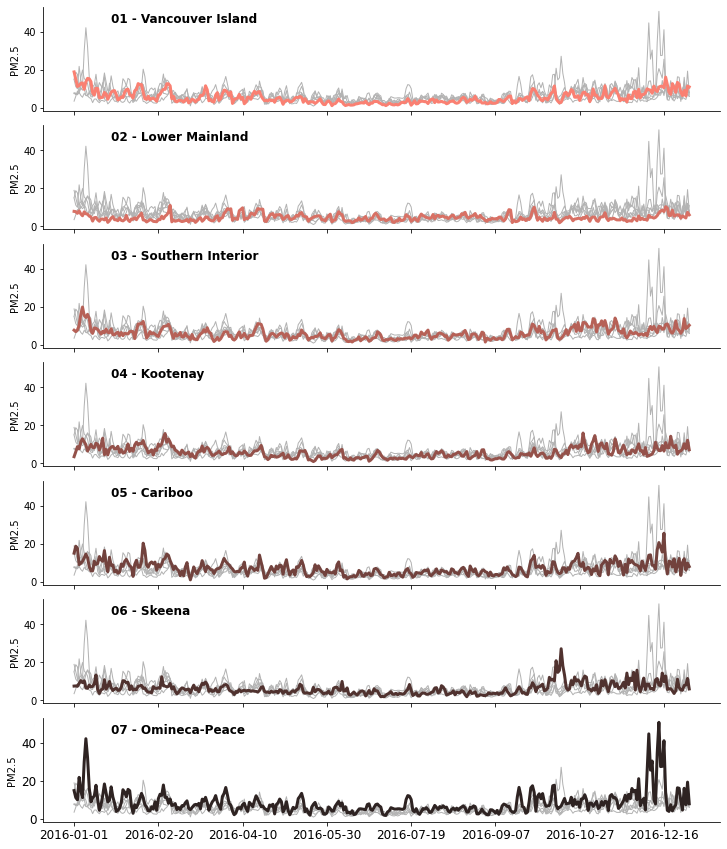

In [ ]:
# Plotting aggregated 2016 dataset
plot_ts(
    data=datasets["PM25_2016_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

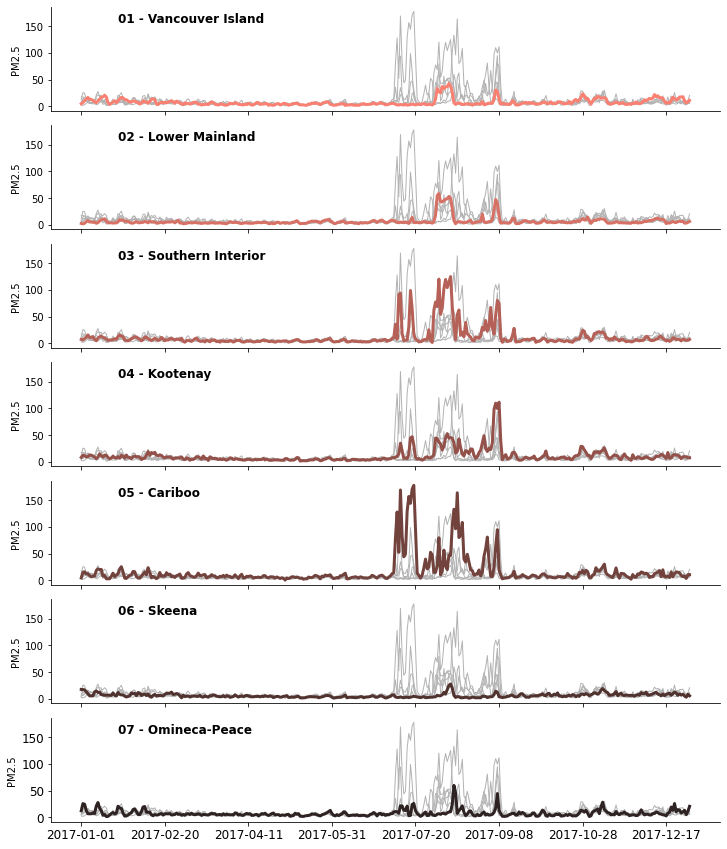

In [ ]:
# Plotting aggregated 2017 dataset
plot_ts(
    data=datasets["PM25_2017_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

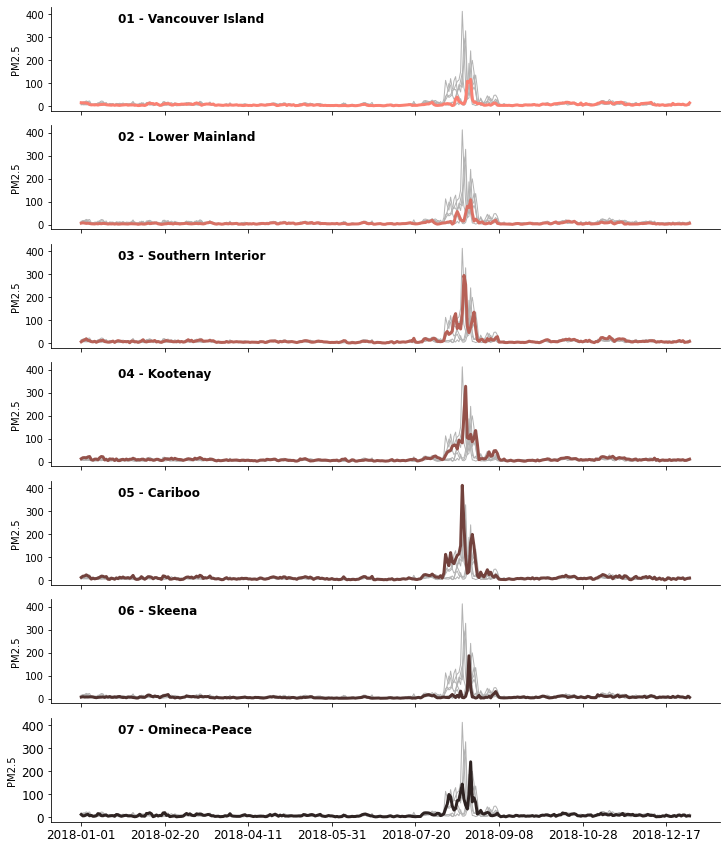

In [ ]:
# Plotting aggregated 2018 dataset
plot_ts(
    data=datasets["PM25_2018_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

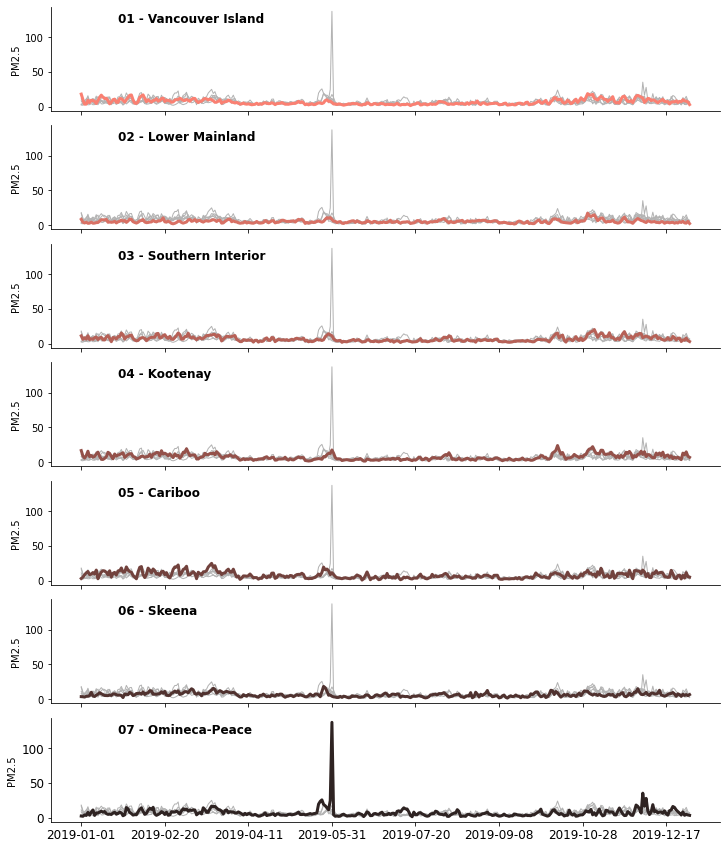

In [ ]:
# Plotting aggregated 2019 dataset
plot_ts(
    data=datasets["PM25_2019_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

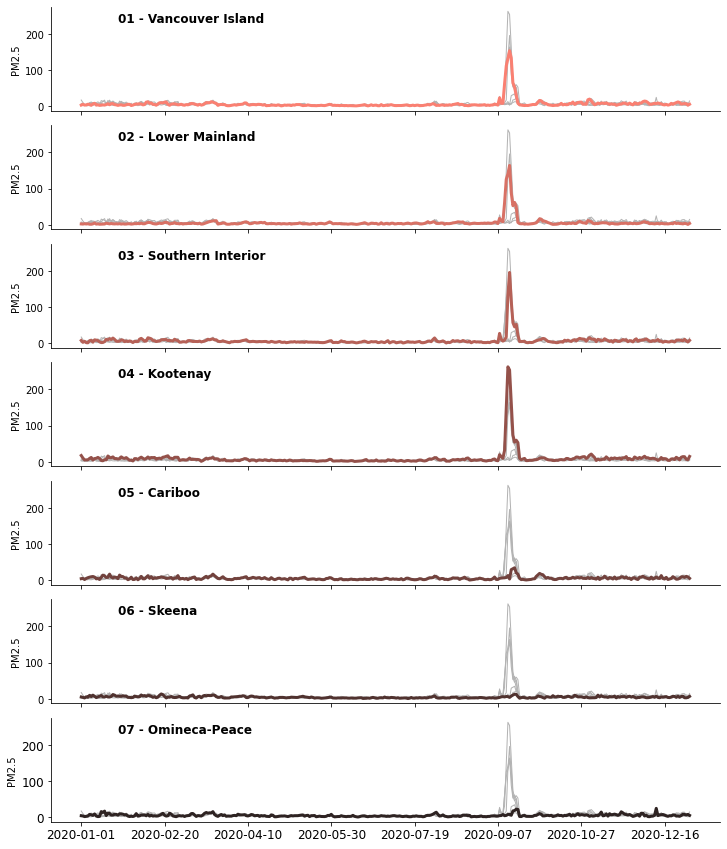

In [ ]:
# Plotting aggregated 2020 dataset
plot_ts(
    data=datasets["PM25_2020_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

In [ ]:
# Removing outliers at threshold cutoff
threshold = 300

for dataset in datasets_list:
    try:
        subset = datasets[dataset][datasets[dataset]["RAW_VALUE"] < threshold]
        grouped_subset = subset.groupby(["REGION", "DATE"]).mean().reset_index()
    except KeyError:
        pass

    # Filtering out unwanted columns
    datasets[f"{dataset}_CLEAN-T_AGG"] = grouped_subset[["REGION", "DATE", "RAW_VALUE"]]
    print(f"{dataset}_CLEAN-T_AGG dim: {datasets[f'{dataset}_CLEAN-T_AGG'].shape}")

PM25_2016_CLEAN-T_AGG dim: (2562, 3)
PM25_2017_CLEAN-T_AGG dim: (2555, 3)
PM25_2018_CLEAN-T_AGG dim: (2555, 3)
PM25_2019_CLEAN-T_AGG dim: (2555, 3)
PM25_2020_CLEAN-T_AGG dim: (2562, 3)
PM25_2021_CLEAN-T_AGG dim: (2562, 3)


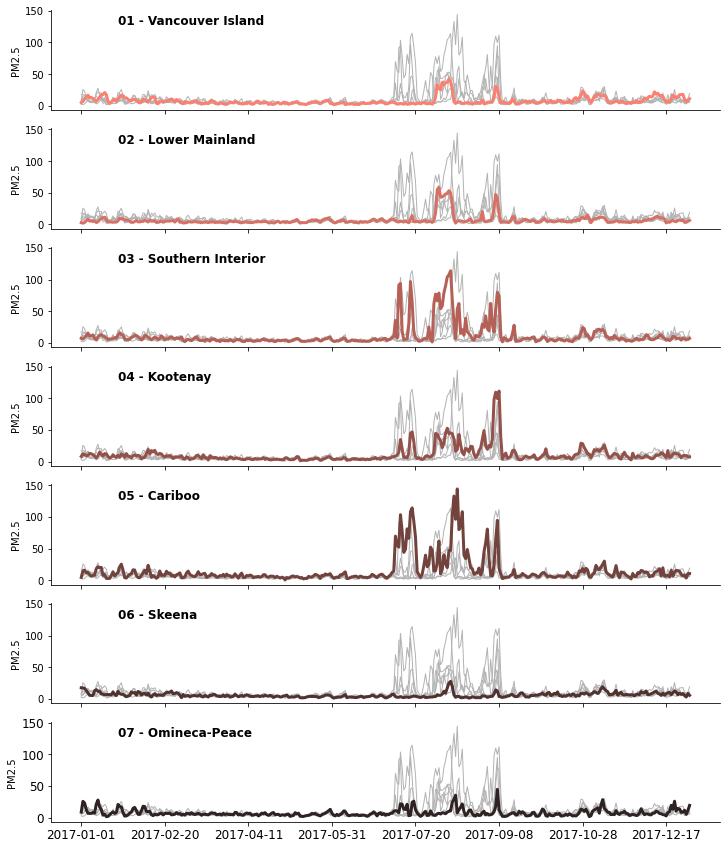

In [ ]:
# Plotting threshold cleaned aggregated 2017 dataset
plot_ts(
    data=datasets["PM25_2017_CLEAN-T_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

In [ ]:
# Removing outliers at top percentile cutoff
percentile = 0.99

for dataset in datasets_list:
    try:
        quantile = datasets[dataset]["RAW_VALUE"].quantile(percentile)
        subset = datasets[dataset][datasets[dataset]["RAW_VALUE"] < quantile]
        grouped_subset = subset.groupby(["REGION", "DATE"]).mean().reset_index()
    except KeyError:
        pass

    # Filtering out unwanted columns
    datasets[f"{dataset}_CLEAN-P_AGG"] = grouped_subset[["REGION", "DATE", "RAW_VALUE"]]
    print(f"{dataset}_CLEAN-P_AGG dim: {datasets[f'{dataset}_CLEAN-P_AGG'].shape}")

PM25_2016_CLEAN-P_AGG dim: (2562, 3)
PM25_2017_CLEAN-P_AGG dim: (2554, 3)
PM25_2018_CLEAN-P_AGG dim: (2551, 3)
PM25_2019_CLEAN-P_AGG dim: (2555, 3)
PM25_2020_CLEAN-P_AGG dim: (2558, 3)
PM25_2021_CLEAN-P_AGG dim: (2558, 3)


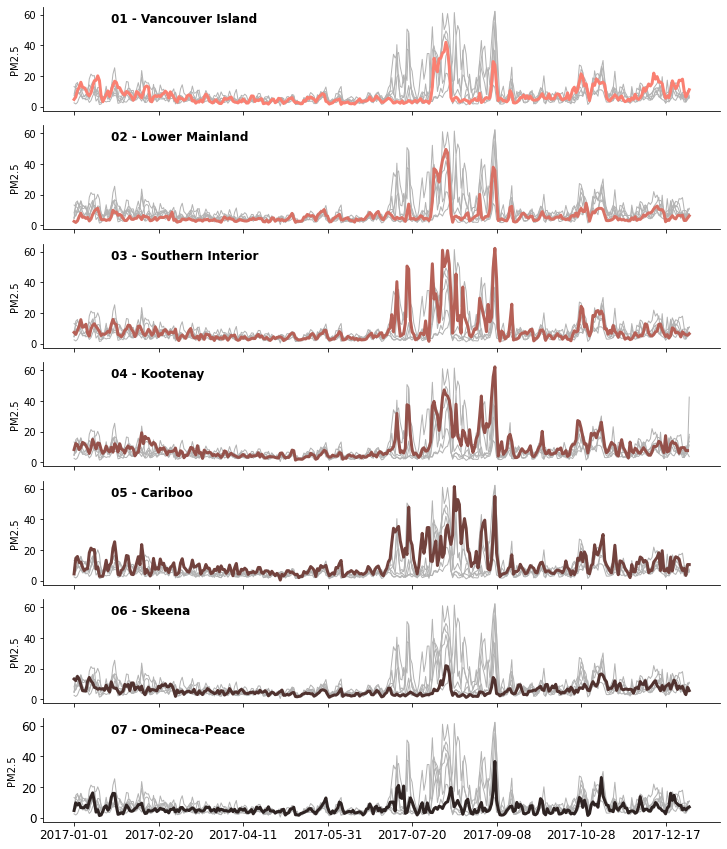

In [ ]:
# Plotting percentile cleaned aggregated 2017 dataset
plot_ts(
    data=datasets["PM25_2017_CLEAN-P_AGG"],
    date="DATE",
    value="RAW_VALUE",
    value_label="PM2.5",
    subset="REGION",
    height=1.7,
    aspect=6,
)

## Subsetting study data
Vancouver Island stations to study:

* Vancouver Clark Drive
* Vancouver International Airport
* Vancouver North Vancouver Mahon Park
* Vancouver North Vancouver Second Narrows

In [ ]:
stations = [
    "Vancouver Clark Drive",
    "Vancouver International Airport #2",
    "North Vancouver Mahon Park",
    "North Vancouver Second Narrows",
]

In [ ]:
for dataset in datasets_list:
    print(dataset)
    for station in stations:
        if station not in datasets[dataset]["STATION_NAME"].unique():
            print(f"Not found: Station {station}")
        else:
            print(f"Found: Station {station}")

PM25_2016
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2017
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2018
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2019
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2020
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2021
Found: Station Vancouver Clark Drive
Found: Station Vancouver Int

In [ ]:
# Concatenating into master datasets
columns = ["DATE_PST", "RAW_VALUE"]
master_dfs = {}

for station in stations:
    master_dfs[station] = []
    for dataset in datasets_list:
        subset = datasets[dataset][columns][
            datasets[dataset]["STATION_NAME"] == station
        ]
        start = min(subset["DATE_PST"])
        end = max(subset["DATE_PST"])
        # Assert time series integrity
        assert len(pd.date_range(start=start, end=end, freq="H")) == subset.shape[0]
        print(f"Appending subset for {station} station from {dataset}...")
        master_dfs[station].append(subset)
    master_dfs[station] = pd.concat(master_dfs[station])
    master_dfs[station].reset_index(drop=True, inplace=True)

Appending subset for Vancouver Clark Drive station from PM25_2016...
Appending subset for Vancouver Clark Drive station from PM25_2017...
Appending subset for Vancouver Clark Drive station from PM25_2018...
Appending subset for Vancouver Clark Drive station from PM25_2019...
Appending subset for Vancouver Clark Drive station from PM25_2020...
Appending subset for Vancouver Clark Drive station from PM25_2021...
Appending subset for Vancouver International Airport #2 station from PM25_2016...
Appending subset for Vancouver International Airport #2 station from PM25_2017...
Appending subset for Vancouver International Airport #2 station from PM25_2018...
Appending subset for Vancouver International Airport #2 station from PM25_2019...
Appending subset for Vancouver International Airport #2 station from PM25_2020...
Appending subset for Vancouver International Airport #2 station from PM25_2021...
Appending subset for North Vancouver Mahon Park station from PM25_2016...
Appending subset for

In [ ]:
# Missing values count per dataset
for dataset in master_dfs.keys():
    missing = sum(master_dfs[dataset]["RAW_VALUE"].isna())
    pct_missing = missing / master_dfs[dataset].shape[0] * 100
    print(f"{missing} ({pct_missing:.2f} %) missing values for {dataset}")

1520 (2.67 %) missing values for Vancouver Clark Drive
547 (0.96 %) missing values for Vancouver International Airport #2
633 (1.11 %) missing values for North Vancouver Mahon Park
2251 (3.95 %) missing values for North Vancouver Second Narrows


In [ ]:
# Writing master datasets csv
for dataset in master_dfs.keys():
    master_dfs[dataset].to_csv(f"output/{dataset.replace(' ', '_')}.csv", index=False)

shutil.make_archive("output", "zip", "output/")

'/content/output.zip'